<a href="https://colab.research.google.com/github/realliyifei/Latex-Template/blob/main/hw3_a3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESE605 Convex Optimization - hw3 (code parts)

In [ ]:
!pip install cvxpy

In [2]:
import cvxpy as cp
import numpy as np

## Warm-up

[link](https://www.cvxpy.org/examples/basic/socp.html)


In [3]:
# Generate a random feasible SOCP.
m = 3
n = 10
p = 5
n_i = 5
np.random.seed(2)
f = np.random.randn(n)
A = []
b = []
c = []
d = []
x0 = np.random.randn(n)
for i in range(m):
    A.append(np.random.randn(n_i, n))
    b.append(np.random.randn(n_i))
    c.append(np.random.randn(n))
    d.append(np.linalg.norm(A[i] @ x0 + b, 2) - c[i].T @ x0)
F = np.random.randn(p, n)
g = F @ x0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
# We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
soc_constraints = [
    cp.SOC(c[i].T @ x + d[i], A[i] @ x + b[i]) for i in range(m)
]
prob = cp.Problem(cp.Minimize(f.T@x),
                  soc_constraints + [F @ x == g])
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)
for i in range(m):
    print("SOC constraint %i dual variable solution" % i)
    print(soc_constraints[i].dual_value)

The optimal value is -9.58269571626638
A solution x is
[ 1.40303325  2.4194569   1.69146656 -0.26922215  1.30825472 -0.70834842
  0.19313706  1.64153496  0.47698583  0.66581033]
SOC constraint 0 dual variable solution
[ 0.61662526  0.35370661 -0.02327185  0.04253095  0.06243588  0.49886837]
SOC constraint 1 dual variable solution
[ 0.35283078 -0.14301082  0.16539699 -0.22027817  0.15440264  0.06571645]
SOC constraint 2 dual variable solution
[ 0.86510445 -0.114638   -0.449291    0.37810251 -0.6144058  -0.11377797]


## CVXBook Extra Exercises 3.3

Each of the following CVX code fragments describes a convex constraint on the scalar variables x, y, and z, but violates the CVX rule set, and so is invalid. Brieﬂy explain why each fragment is invalid. Then, rewrite each one in an equivalent form that conforms to the CVX rule set. In your reformulations, you can use linear equality and inequality constraints, and inequalities constructed using CVX functions. You can also introduce additional variables, or use LMIs. Be sure to explain (brieﬂy) why your reformulation is equivalent to the original constraint, if it is not obvious.

Check your reformulations by creating a small problem that includes these constraints, and solving it using CVX. Your test problem doesn’t have to be feasible; it’s enough to verify that CVX processes your constraints without error.

### Ref

* [The DCP ruleset — CVX Users' Guide](http://web.cvxr.com/cvx/doc/dcp.html#)

In [12]:
# Helper: solve and print
def solve_and_print(obj, constraints):
    prob = cp.Problem(obj, constraints) # Form problem
    prob.solve()  # Solve problem and return optima
    print("status:", prob.status)
    print("optimal value:", prob.value)
    print("optimal var:", x.value, y.value)

(a) $norm([x + 2*y, x - y]) == 0$

Invalid because for equality constraint, both side should be affine, while here LHS is not. We here try to let (x,y) be zero

In [33]:
x, y = cp.Variable(), cp.Variable() # Initialize
constraints = [x - y == 0] # Constraints
obj = cp.Minimize((x - y + 2)**2) # Objective function
solve_and_print(obj, constraints) # Solve and print

status: optimal
optimal value: 4.0
optimal var: 8.840090183351419e-11 8.840090183351419e-11


(b) $square(square(x + y)) <= x - y$

Invalid because square function is neither noodecreasing or nonincreasing then it should be affine. Here we try to let it be affine inside.

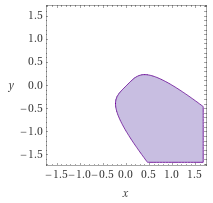

In [17]:
x, y = cp.Variable(), cp.Variable() 
constraints = [(x + y) ** 4 <= x - y]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

status: optimal
optimal value: 3.9999998921764797
optimal var: -6.20074789185704e-09 6.200747891855019e-09


(c) $1/x + 1/y <= 1; x >= 0; y >= 0$

Invalid because a valid call to a function here should be convex while $1/x$ isn't. Here we try to replace it equivalently with a convex function.

In [18]:
x, y = cp.Variable(), cp.Variable() 
constraints = [cp.inv_pos(x) + cp.inv_pos(y) <= 1]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

status: optimal
optimal value: -1.8639133848843673e-10
optimal var: 3.4855490882933275 5.485548349915387


(d) $norm([max(x,1), max(y,2)]) <= 3*x + y$

Invalid because norm function is convex yet neither nondecreasing nor nonincreasing and therefore it should accept affine function. Here we try to introduce new variables to get access to the maximum without violating this rule.

In [42]:
x, y = cp.Variable(), cp.Variable() 
z = cp.Variable(2) # two new variables
z1, z2 = cp.Variable(), cp.Variable() 
constraints = [cp.norm(z) <= 3 * x + y,
               z[0] >= cp.maximum(x, 1), 
               z[1] >= cp.maximum(y, 2)]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

status: optimal
optimal value: -2.6952363848775156e-10
optimal var: 1.536021428597174 3.536026130153923


(e) $x*y >= 1; x >= 0; y >= 0$

Invalid because $x*y$ is neither convex nor concave. Here we try to move $y$ from LHS to RHS to avoid this function construction.

In [23]:
x, y = cp.Variable(), cp.Variable() 
constraints = [x >= cp.inv_pos(y), x >= 0, y >= 0]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

status: optimal
optimal value: 6.483921143371596e-12
optimal var: 1.813243728454946 3.813243505987337


(f) $(x + y)^2/sqrt(y) <= x - y + 5$

Invalid because a division between convex and concave function is unacceptable (?)

In [25]:
x, y = cp.Variable(), cp.Variable() 
constraints = [cp.quad_over_lin(x + y, cp.sqrt(y)) <= x - y + 5, 
               y >= 0, x >= y - 5]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

status: optimal
optimal value: 3.5463258630455323e-11
optimal var: -1.0220708215172787 0.9779288503062095


(g) $x^3 + y^3 <= 1; x >= 0; y >= 0$

Invalid because $x^3$ is not convex on the LHS of coordiation. Here we try to rewrite the function to make it convex.

In [26]:
x, y = cp.Variable(), cp.Variable() 
constraints = [cp.pos(x) ** 3 + cp.pos(y) ** 3 <= 1, 
               x >= 0, y >= 0]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

status: optimal
optimal value: 0.9999999966406441
optimal var: -7.308453388112953e-11 1.0000000009796675


(h) $x + z <= 1 + sqrt(x*y - z^2); x >= 0; y >= 0$

In [31]:
def quad_over_lin(X, y):
    t = cp.Variable()
    expr = cp.vstack([2*X, y[None,:]-t])
    constr = cp.SOC(y-t, expr, axis=0)
    return t, constr

x, y, z = cp.Variable(), cp.Variable(), cp.Variable() 
constraints = 
# constraints = [x + z <= 1 + cp.geo_mean(x, y - cp.quad_over_lin(z, z)),
#                x >= 0, y >= 0]
obj = cp.Minimize((x - y + 2)**2)
solve_and_print(obj, constraints)

TypeError: ignored

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
!cp drive/My Drive/ESE605/a3.3.ipynb ./

cp: cannot stat 'drive/My': No such file or directory
cp: cannot stat 'Drive/ESE605/a3.3.ipynb': No such file or directory


In [ ]:
!jupyter nbconvert --execute --to pdf a3.3.ipynb